In [1]:
import mysql.connector
from mysql.connector import Error
import config

In [2]:
import pandas as pd
import seaborn as sns

# Database Connection

In [3]:
connection = None
try:
    connection = mysql.connector.connect(
        host=config.HOST,
        user=config.USER,
        passwd=config.PW,
        database=config.DB_NAME
    )
    print("MySQL Database connection successful")
except Error as err:
    print(f"Error: '{err}'")

MySQL Database connection successful


# Read Tables

In [4]:
def read_table(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
    except Error as err:
        print(f"Error: '{err}'")
    return result

In [5]:
# Table: hand
query = "SELECT * FROM hand;"
hands = read_table(connection, query)

hand_columns = ['hand_id', 'datetime', 'button', 'small_blind', 'big_blind', 'ante', 'flop_1', 'flop_2', 'flop_3', 'turn', 'river', 'total_pot', 'rake', 'is_showdown']
hand_df = pd.DataFrame(hands, columns=hand_columns)
hand_df = hand_df.set_index('hand_id')

In [6]:
# Table: participant
query = "SELECT * FROM participant;"
participants = read_table(connection, query)
    
participant_columns = ['name', 'hand_id', 'starting_stack', 'ending_stack', 'seat']
participant_df = pd.DataFrame(participants, columns=participant_columns)

In [7]:
# Table: action
query = "SELECT * FROM action;"
actions = read_table(connection, query)
    
action_columns = ['hand_id', 'action_number', 'street', 'player_name', 'type', 'size']
action_df = pd.DataFrame(actions, columns=action_columns)

In [8]:
# Table: cards
query = "SELECT * FROM cards;"
cards = read_table(connection, query)
    
cards_columns = ['hand_id', 'player_name', 'card_1', 'card_2']
cards_df = pd.DataFrame(cards, columns=cards_columns)

# New Columns

In [9]:
# Generate general hand combo. Ex: AKo is the general type of Ace of clubs, King of spades (Ace King Offsuit).
def get_general_combo(card_1, card_2):
    card_values = 'AKQJT98765432'
    if card_1[0] == card_2[0]:
        # Pocket pair
        return card_1[0] + card_2[0]
    value_1 = card_values.index(card_1[0])
    value_2 = card_values.index(card_2[0])
    if value_1 > value_2:
        high_card = card_values[value_2]
        low_card = card_values[value_1]
    else:
        high_card = card_values[value_1]
        low_card = card_values[value_2]
    if card_1[1] == card_2[1]:
        # Suited
        return f'{high_card}{low_card}s'
    return f'{high_card}{low_card}o'

In [10]:
# Add general hand combo to cards data
cards_df['combo'] = cards_df.apply(lambda x: get_general_combo(x['card_1'], x['card_2']), axis=1)

In [11]:
# Use preflop_raises_df for pfr column and number of preflop raises
preflop_raises_df = action_df.loc[(action_df['type'] == 'R') & (action_df['street'] == 'preflop')]

In [12]:
# Add PFR to hand
pfr_df = preflop_raises_df.groupby(['hand_id'])['player_name'].apply(list).apply(lambda x: None if not x else x[-1])
pfr_df.name = 'pfr'
hand_df = pd.concat([hand_df, pfr_df], axis=1)

In [13]:
# Add number of preflop raises
nb_raises_preflop_df = preflop_raises_df.groupby(['hand_id'])['player_name'].apply(list).apply(lambda x: len(x))
nb_raises_preflop_df.name = 'preflop_raises'
hand_df = pd.concat([hand_df, nb_raises_preflop_df], axis=1)
hand_df['preflop_raises'] = hand_df['preflop_raises'].fillna(0).astype(int)

In [14]:
# Returns hero line to hand
def get_player_line(hand_id, player_action_df):
    df = player_action_df.loc[player_action_df['hand_id'] == hand_id]
    line_df = df.groupby('street')['type'].apply(list)
    line = ''
    if 'preflop' in line_df.index:
        for action_type in line_df.loc['preflop']:
            line += action_type
    if 'flop' in line_df.index:
        line += ','
        for action_type in line_df.loc['flop']:
            line += action_type
    if 'turn' in line_df.index:
        line += ','
        for action_type in line_df.loc['turn']:
            line += action_type
    if 'river' in line_df.index:
        line += ','
        for action_type in line_df.loc['river']:
            line += action_type
    return line

In [15]:
# *There is probably a way to speed this up by using .groupby() and skipping get_player_line() function
player_action_df = action_df[action_df['player_name'] == 'gablabzmoney']
hand_df['hero_line'] = hand_df.apply(lambda x: get_player_line(x.name, player_action_df), axis=1)

In [16]:
hand_df

,datetime,button,small_blind,big_blind,ante,flop_1,flop_2,flop_3,turn,river,total_pot,rake,is_showdown,pfr,preflop_raises,hero_line
hand_id,,,,,,,,,,,,,,,,
231630431940,2021-11-22 22:21:24,1,0.05,0.10,0.0,None,None,None,None,None,0.10,0.00,0,NaN,0,
231630431945,2021-11-22 22:21:24,1,0.05,0.10,0.0,9c,3d,3s,5d,Kd,2.87,0.13,0,abacu20,1,F
231630434349,2021-11-22 22:21:36,1,0.05,0.10,0.0,None,None,None,None,None,0.25,0.00,0,rayban07,1,F
231630434749,2021-11-22 22:21:38,1,0.05,0.10,0.0,2h,8h,4c,Qd,None,0.72,0.03,0,gablabzmoney,1,"R,X,B"
231630435339,2021-11-22 22:21:41,1,0.05,0.10,0.0,Ks,Js,Kh,8c,4c,1.61,0.07,1,ImMikeRoss,1,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250488804167,2024-05-13 22:04:34,1,0.05,0.10,0.0,None,None,None,None,None,0.25,0.00,0,nyanchuuuu,1,F
250488804759,2024-05-13 22:04:38,1,0.05,0.10,0.0,4d,6h,5h,Th,Qs,1.96,0.09,0,notilt.sitilt,1,"C,C,B,B"
250488804971,2024-05-13 22:04:39,1,0.10,0.25,0.0,9s,Qs,Qh,None,None,1.30,0.06,0,gablabzmoney,1,"R,B"


# Filters

In [17]:
def filter_by_date(df, from_dt=None, to_dt=None):
    if from_dt:
        df = df[df['datetime'] > from_dt]
    if to_dt:
        df = df[df['datetime'] < to_dt]
    return df

# Winnings Graphs

In [18]:
def winnings_df(hand_df, participant_df, hero_name, big_blind=None):
    if big_blind:
        hand_df = hand_df[hand_df['big_blind'] == big_blind]
    player_df = participant_df[participant_df['name'] == hero_name]
    df = pd.merge(hand_df, player_df, on="hand_id")
    total = 0
    total_series = []
    for index, row in df.iterrows():
        total += row['ending_stack'] - row['starting_stack']
        total_series.append(total)
    df['winnings'] = pd.Series(total_series)
    return df

In [19]:
sns.set_theme()

[Text(0.5, 0, 'Hand'),
 Text(0, 0.5, 'Winnings in $'),
 Text(0.5, 1.0, 'Total Winnings')]

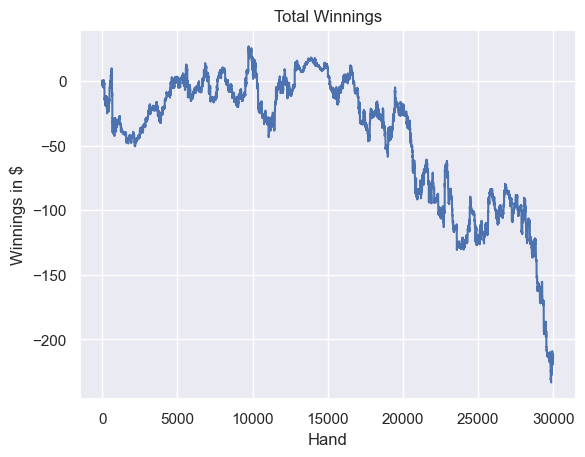

In [20]:
total_winnings_df = winnings_df(hand_df, participant_df, 'gablabzmoney')
graph = sns.lineplot(x=total_winnings_df.index, y="winnings", data=total_winnings_df)
graph.set(xlabel='Hand', ylabel='Winnings in $', title='Total Winnings')

[Text(0.5, 0, 'Hand'),
 Text(0, 0.5, 'Winnings in $'),
 Text(0.5, 1.0, 'Winnings 10NL')]

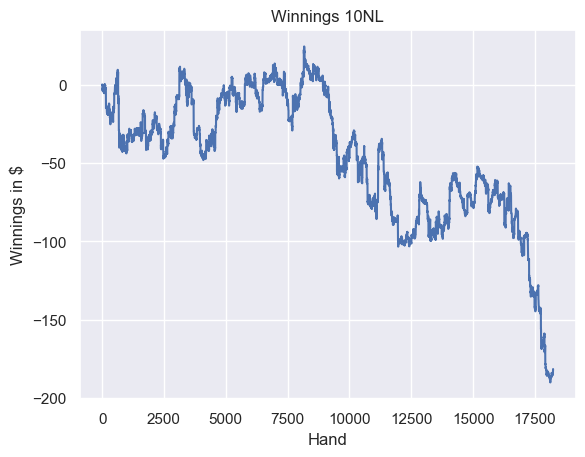

In [21]:
NL10_winnings_df = winnings_df(hand_df, participant_df, 'gablabzmoney', big_blind=0.1)
graph = sns.lineplot(x=NL10_winnings_df.index, y="winnings", data=NL10_winnings_df)
graph.set(xlabel='Hand', ylabel='Winnings in $', title='Winnings 10NL')

## Winnings graph as 3bettor

[Text(0.5, 0, 'Hand'),
 Text(0, 0.5, 'Winnings in $'),
 Text(0.5, 1.0, 'Winnings as 3bettor')]

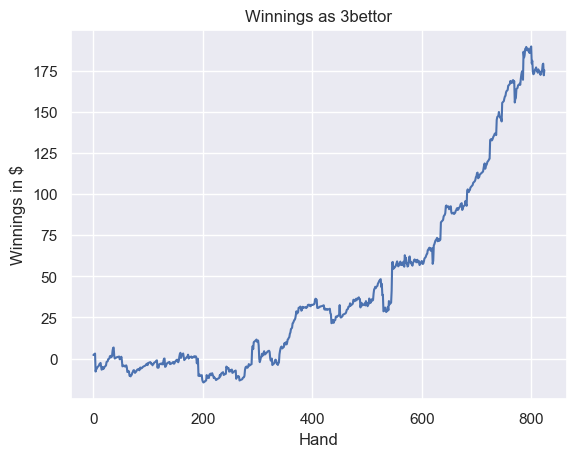

In [22]:
hero_name = 'gablabzmoney'
df = hand_df[(hand_df['pfr'] == hero_name) & (hand_df['preflop_raises'] == 2)]
winnings_3bettor_df = winnings_df(df, participant_df, hero_name)
graph = sns.lineplot(x=winnings_3bettor_df.index, y="winnings", data=winnings_3bettor_df)
graph.set(xlabel='Hand', ylabel='Winnings in $', title='Winnings as 3bettor')

# Hand Heatmap

In [23]:
CARD_VALUES = 'AKQJT98765432'

In [24]:
def to_cell_number(combo):
    if combo[0] == combo[1]:
        return CARD_VALUES.index(combo[0]), CARD_VALUES.index(combo[1])
    elif combo[2] == 's':
        return CARD_VALUES.index(combo[0]), CARD_VALUES.index(combo[1])
    else:
        return CARD_VALUES.index(combo[1]), CARD_VALUES.index(combo[0])

In [25]:
# Create combo matrix
matrix = []
for i, value1 in enumerate(CARD_VALUES):
    row = []
    for j, value2 in enumerate(CARD_VALUES):
        if i == j:
            row.append(value1 + value2)
        elif i < j:
            row.append(value1 + value2 + 's')
        else:
            row.append(value2 + value1 + 'o')
    matrix.append(row)
columns = [value for value in CARD_VALUES]
index = [value for value in CARD_VALUES]
combos_df = pd.DataFrame(matrix, index=index, columns=columns)
combos_df

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,AA,AKs,AQs,AJs,ATs,A9s,A8s,A7s,A6s,A5s,A4s,A3s,A2s
K,AKo,KK,KQs,KJs,KTs,K9s,K8s,K7s,K6s,K5s,K4s,K3s,K2s
Q,AQo,KQo,QQ,QJs,QTs,Q9s,Q8s,Q7s,Q6s,Q5s,Q4s,Q3s,Q2s
J,AJo,KJo,QJo,JJ,JTs,J9s,J8s,J7s,J6s,J5s,J4s,J3s,J2s
T,ATo,KTo,QTo,JTo,TT,T9s,T8s,T7s,T6s,T5s,T4s,T3s,T2s
9,A9o,K9o,Q9o,J9o,T9o,99,98s,97s,96s,95s,94s,93s,92s
8,A8o,K8o,Q8o,J8o,T8o,98o,88,87s,86s,85s,84s,83s,82s
7,A7o,K7o,Q7o,J7o,T7o,97o,87o,77,76s,75s,74s,73s,72s
6,A6o,K6o,Q6o,J6o,T6o,96o,86o,76o,66,65s,64s,63s,62s
5,A5o,K5o,Q5o,J5o,T5o,95o,85o,75o,65o,55,54s,53s,52s


In [26]:
# Create hand count matrix and winnings by combo matrix
columns = [value for value in CARD_VALUES]
index = [value for value in CARD_VALUES]

df_combo_count = pd.DataFrame(0, index=index, columns=columns)
df_winnings_by_combo = pd.DataFrame(0.0, index=index, columns=columns)

hero_cards_df = cards_df[cards_df['player_name'] == "gablabzmoney"][['hand_id', 'combo']]
df = pd.merge(total_winnings_df, hero_cards_df, on="hand_id")

for index, row in df.iterrows():
    x, y = to_cell_number(row['combo'])
    df_combo_count.iat[x, y] += 1
    df_winnings_by_combo.iat[x, y] += row['ending_stack'] - row['starting_stack']
df_combo_count

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,137,119,100,97,84,92,81,91,96,84,93,97,93
K,261,134,98,81,83,78,88,86,90,103,77,90,78
Q,265,268,135,96,83,93,96,98,89,85,74,98,96
J,271,264,276,122,94,91,86,88,94,89,78,98,74
T,255,285,293,248,147,92,102,88,91,81,87,74,81
9,293,262,291,279,293,130,94,84,81,106,83,95,94
8,240,270,274,272,277,298,141,92,82,92,79,99,96
7,269,253,284,287,276,284,284,138,93,106,102,80,99
6,227,281,271,272,283,272,278,276,143,88,101,100,89
5,283,273,303,288,262,239,274,269,274,133,102,102,84


In [27]:
df_winnings_by_combo

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,128.10,34.65,10.54,13.22,3.27,20.50,12.66,-8.82,5.24,-5.71,11.36,-6.60,-12.30
K,-15.75,50.05,-4.05,-7.83,-8.08,-2.11,-2.52,3.58,-1.95,-5.66,-0.89,-6.38,-0.70
Q,39.10,11.20,12.13,-3.04,-16.14,26.87,-1.83,1.90,-3.17,-2.56,-1.64,1.41,-1.31
J,-3.93,-5.12,-10.86,22.24,1.61,-1.92,-12.86,1.43,-4.05,-0.54,0.86,2.46,-0.33
T,-6.61,-12.94,-22.60,-17.49,13.58,0.82,18.36,3.77,2.49,0.51,-0.70,-2.70,-6.69
9,-4.93,5.23,-12.33,-11.50,1.50,-36.15,-3.52,-1.66,-18.98,2.85,-4.59,-0.88,-0.80
8,0.12,-6.45,-1.35,-10.76,3.63,5.34,42.35,-4.21,4.57,-5.32,-9.40,-1.23,-2.43
7,-26.02,-12.73,-6.06,-5.53,-3.48,-2.55,-6.16,14.69,3.28,-10.70,-2.83,-1.05,-10.98
6,2.53,-8.66,-7.10,-3.06,-3.54,-7.53,-3.54,10.79,-19.02,-18.39,-6.60,-9.54,-1.01
5,-16.01,-1.41,-7.85,-11.76,-3.81,-3.76,-6.03,-10.67,-2.41,-6.72,1.39,8.18,-4.52


In [28]:
from  matplotlib.colors import LinearSegmentedColormap
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.47,.5,0.53,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

<Axes: >

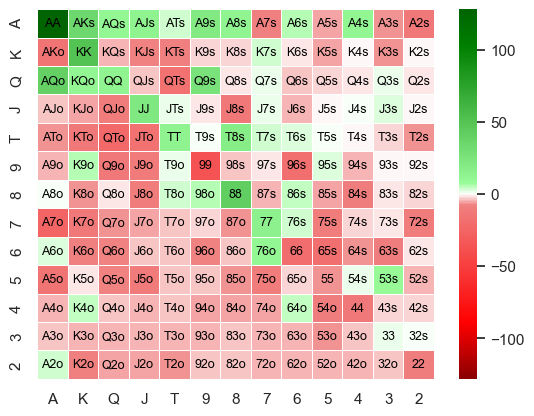

In [29]:
# Select vmax as AA winnings
vmax = df_winnings_by_combo.iloc[0, 0]
vmin = -vmax
sns.heatmap(df_winnings_by_combo.rename_axis(index=None, columns=None), vmin=vmin, vmax=vmax, cmap=cmap, linewidth=.5, annot=combos_df, fmt='', annot_kws={'size': 9, 'color':'black'})

# By Positions

In [105]:
# Positions are always the same on Zoom tables, but will need to make it robust for other format.
positions = ['BU', 'SB', 'BB', 'MP', 'HJ', 'CO']
participant_df['position'] = participant_df.apply(lambda x: positions[x['seat'] - 1], axis=1)

In [90]:
hero_df = participant_df[participant_df['name'] == 'gablabzmoney']

In [91]:
def filter_by_position(hand_df, hero_df, position):
    bb_df = hero_df[hero_df['position'] == position]
    return hand_df[hand_df.index.isin(bb_df['hand_id'])]

In [98]:
def produce_graph_by_pos(hand_df, hero_df, position):
    pos_df = filter_by_position(hand_df, hero_df, position)
    pos_winnings_df = winnings_df(pos_df, participant_df, 'gablabzmoney')
    graph = sns.lineplot(x=pos_winnings_df.index, y="winnings", data=pos_winnings_df)
    graph.set(xlabel='Hand', ylabel='Winnings in $', title='Winnings as ' + position)

## Big blind

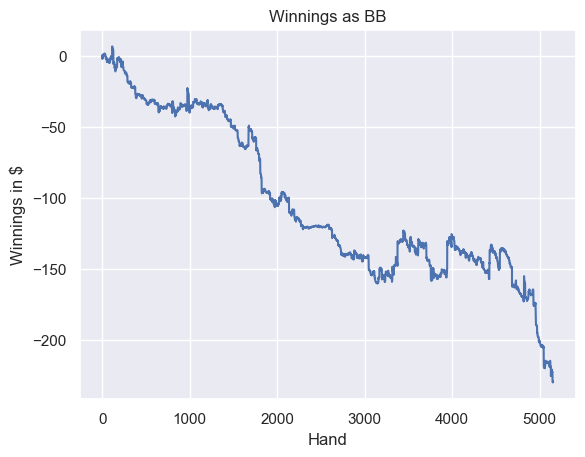

In [100]:
produce_graph_by_pos(hand_df, hero_df, 'BB')

## Small blind

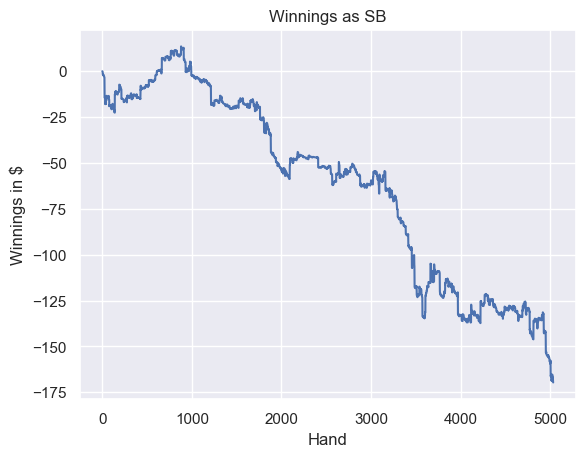

In [99]:
produce_graph_by_pos(hand_df, hero_df, 'SB')

## Button

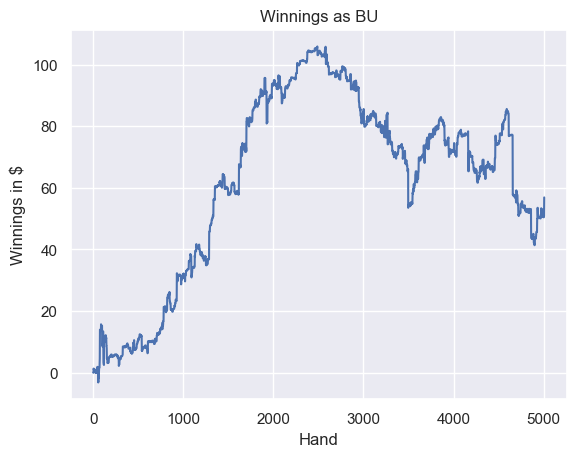

In [101]:
produce_graph_by_pos(hand_df, hero_df, 'BU')

## CutOff

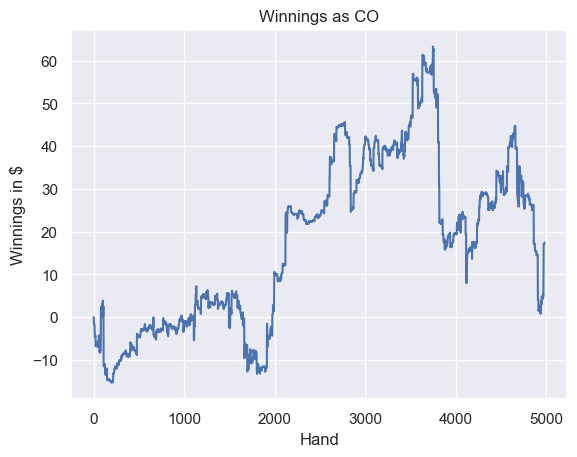

In [102]:
produce_graph_by_pos(hand_df, hero_df, 'CO')

## Hijack

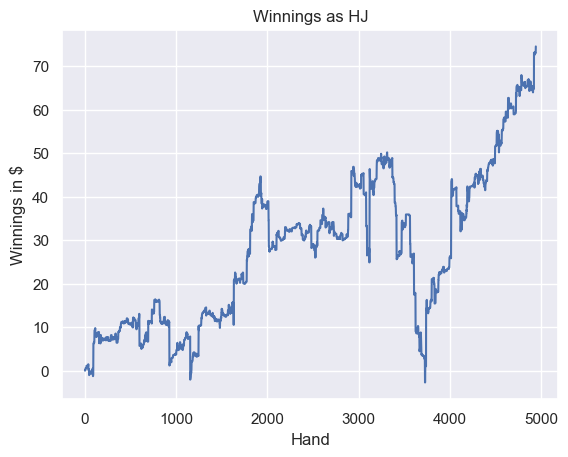

In [103]:
produce_graph_by_pos(hand_df, hero_df, 'HJ')

## Middle Position

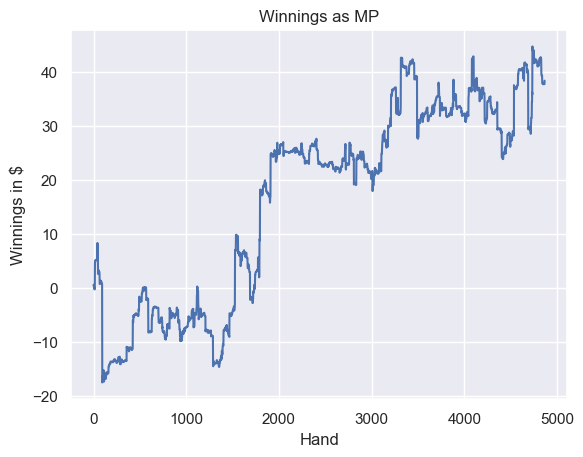

In [104]:
produce_graph_by_pos(hand_df, hero_df, 'MP')